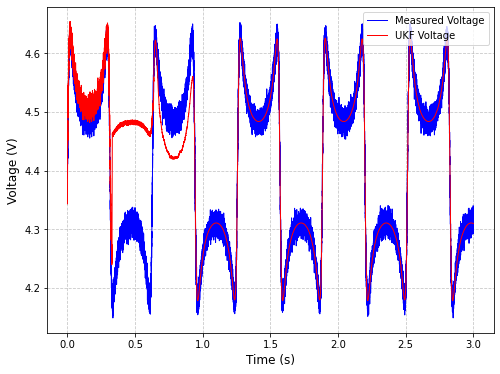

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randn
from filterpy.kalman import UnscentedKalmanFilter
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import MerweScaledSigmaPoints

# Parameters
nDensity = 6.0952 * 1e13  # cm-3
Ipump = 5  # mW
eta = 1  # PD conversion
L = 3 * 1e-2  # cm
sigma_op = 2.34601 * 1e-13  # cm2
S0 = 0.7
timeInterval = 1e-4

# Magnetic parameter
def magnetic(t):
    t = np.asarray(t)
    return 5 * np.sin(10 * t)

# Single pump atomic magnetometer model
def fx(x, dt):
    x_update = np.empty_like(x)
    x_update[0] = x[0] + dt
    x_update[1] = magnetic(x[0]+dt)
    x_update[2] = 0.34 * S0 * x_update[1] / (1 + x_update[1]**2) + S0
    return x_update

def hx(x):
    V_PD = eta * Ipump * np.exp(-nDensity * sigma_op * L * (1-x[2]))
    return [V_PD]

# UKF and sample points
points = MerweScaledSigmaPoints(n=3, alpha=.1, beta=2., kappa=-1)
ukf = UnscentedKalmanFilter(dim_x=3, dim_z=1, dt=timeInterval, hx=hx, fx=fx, points=points)

# UKF setting & experiment
ukf.x = np.array([0., 0., S0])  # state init
ukf.R = np.diag([0.01])  # measurement noise
ukf.Q = Q_discrete_white_noise(3, dt=0.1, var=0.001)  # process noise

# Tracking
Nnum = int(3e4)
time = [i*timeInterval for i in range(Nnum)]
Bz = [magnetic(t) for t in time]
Pz = []
Voltage = []
for i in Bz:
    Pz_next = 0.34 * S0 * i / (1 + i**2) + S0
    Pz.append(Pz_next)
    Voltage.append(eta * Ipump * np.exp(-nDensity * sigma_op * L * (1 - Pz_next)))
Voltage_measure = [i + randn() * 0.01 for i in Voltage]

# UKF and plot
uxs = []
uys = []
for z in Voltage_measure:
    ukf.predict()
    ukf.update(z)
    uxs.append(ukf.x.copy())
    uys.append(hx(uxs[-1]))
uxs = np.array(uxs)
uys = np.array(uys)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(time, Voltage_measure, label='Measured Voltage', linewidth=1, color='blue')
plt.plot(time, uys, label='UKF Voltage', linewidth=1, color='red')
plt.legend(fontsize=10, loc='upper right')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Voltage (V)', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.savefig('plotUKF_v1.png', dpi=300, bbox_inches='tight')
